In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

/Users/eatingyeh/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Read files into dataframe using pandas
def open_file(file_name):
    input_dir = r'./'
    try:
        #use pandas to create dataframe
        df = pd.read_csv(os.path.join(input_dir, file_name + '.csv'))
        return df
    
    except Exception as e:
        print(e)
        print('failed to read the file: ', file_name)

In [3]:
#read in excel file and save in dataframe
ecom = open_file('ecom')

## Data Cleaning

In [4]:
ecom.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [5]:
ecom.shape

(294478, 5)

In [6]:
ecom.nunique()

id           290584
time          35993
con_treat         2
page              2
converted         2
dtype: int64

In [7]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
id           294478 non-null int64
time         294478 non-null object
con_treat    294478 non-null object
page         294478 non-null object
converted    294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
ecom.isnull().sum()

id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

In [9]:
# make sure if the number of new_page and treatment match
numTreat = ecom[ecom["con_treat"] == "treatment"].shape[0]
numNewpage = ecom[ecom["page"] == "new_page"].shape[0]
difference = numTreat - numNewpage

pd.DataFrame({
    'N treatment': [numTreat],
    'N new_page': [numNewpage],
    'Difference': [difference]
})

,Difference,N new_page,N treatment
0,37,147239,147276


There are 37 differences between the new page and treatment, which may bring problems to the data.

In [10]:
ecom_mismatch = ecom[(ecom["con_treat"] == "treatment") & (ecom["page"] == "old_page")
               |(ecom["con_treat"] == "control") & (ecom["page"] == "new_page")]

n_mismatch = ecom_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(ecom) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 percent


Since we found out that there are mismatch in new_page and treatment, we also do it for old_page and control, which finds out that there's about 1.32% of mismatch in total.

In [11]:
ecom_match = ecom[(ecom["con_treat"] == "treatment") & (ecom["page"] == "new_page")
            |(ecom["con_treat"] == "control") & (ecom["page"] == "old_page")]

ecom_match.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [12]:
# Check if we actually remove all of the incorrect rows
ecom_match[((ecom_match['con_treat'] == 'treatment') == (ecom_match['page'] == 'new_page')) == False].shape[0]

0

In [13]:
# show duplicates
ecom_match[ecom_match.duplicated("id") == True]

,id,time,con_treat,page,converted
2893,773192,55:59.6,treatment,new_page,0


In [14]:
# drop the duplicates if any
ecom_match = ecom_match.drop_duplicates("id") 

In [15]:
# Check that the duplicates is actually dropped
len(ecom_match) - ecom_match.id.nunique()

0

## EDA

conversion rate for all

In [16]:
print('Conversion rate:', ecom_match['converted'].mean())

Conversion rate: 0.11959708724499628


conversion rate given the group (control/treatment)

In [17]:
# Given the user is in the control/treatment group, the conversion rate is as follows
ecom_match.groupby('con_treat')['converted'].mean()

con_treat
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

probability of a user receiving the new page

In [18]:
len(ecom_match[ecom_match['page'] == 'new_page'])/len(ecom_match)

0.5000619442226688

## A/B test with sampling distribution

Assuming that the old page is better unless the new one is proved to be significantly better at alpha=5%

𝐻0 :  P𝑜𝑙𝑑  -  P𝑛𝑒𝑤   >=0 

𝐻1 :  P𝑜𝑙𝑑  -  P𝑛𝑒𝑤   <0

In [19]:
# Create sampling distribution of difference in means
means_diff = []

for _ in range(10000):
    sample = ecom_match.sample(ecom.shape[0], replace = True)
    control_mean = sample[sample['con_treat'] == 'control']['converted'].mean()
    treatment_mean = sample[sample['con_treat'] == 'treatment']['converted'].mean()
    means_diff.append(treatment_mean-control_mean)

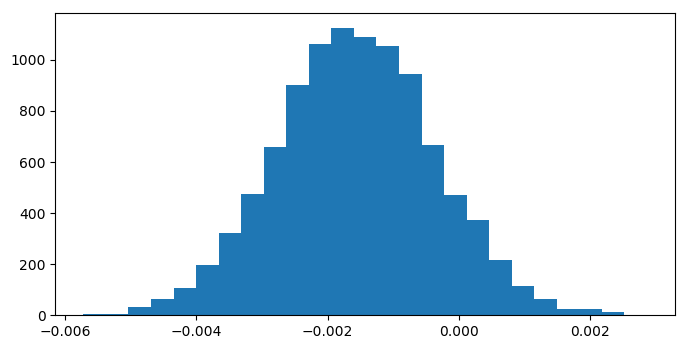

In [20]:
# Plot the sampling distribution 
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [22]:
# null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

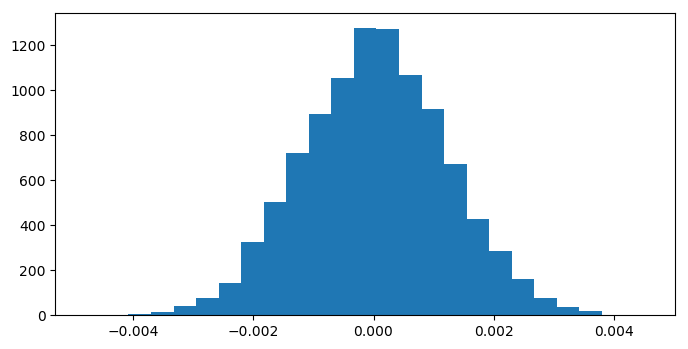

In [23]:
# Plot the null distribution
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

In [21]:
control_mean = ecom_match[ecom_match['con_treat'] == 'control']['converted'].mean()
treatment_mean = ecom_match[ecom_match['con_treat'] == 'treatment']['converted'].mean()

observed_diff = treatment_mean - control_mean

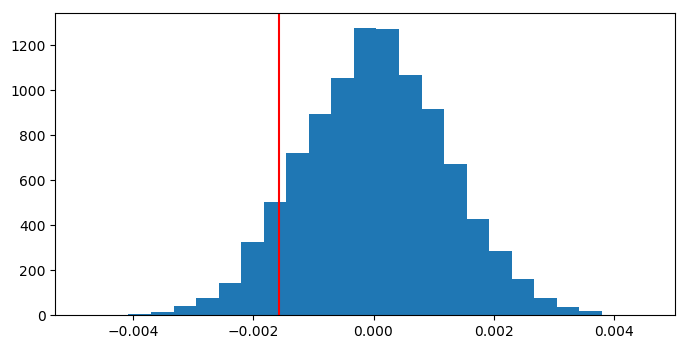

In [24]:
# Plot observed distribution under null hypothesis
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(observed_diff, c='red')
plt.show()

In [28]:
# p value 
(null_vals > observed_diff).mean()

0.90490000000000004

## A/B test with t test

In [29]:
import statsmodels.api as sm

In [31]:
convert_old = ecom_match[(ecom_match["converted"] == 1) & (ecom_match["page"] == "old_page")]['id'].nunique()
convert_new = ecom_match[(ecom_match["converted"] == 1) & (ecom_match["page"] == "new_page")]['id'].nunique()
n_old = ecom_match[ecom["page"] == "old_page"]['id'].nunique()
n_new = ecom_match[ecom["page"] == "new_page"]['id'].nunique()

/Users/eatingyeh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/eatingyeh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [32]:
#Compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [33]:
# Print Z Score and P_Value
z_score, p_value 

(-1.3109241984234394, 0.90505831275902449)

P value of around 0.9 under both methods is much higher than the alpha, which means we don't have significant evidence to reject the null hypothesis. And that we may conclude there is no significant impact for the new page.